In [3]:
import os               
import numpy                   as np
import pandas                  as pd 
import matplotlib.pyplot       as plt
import seaborn                 as sns
import plotly.express          as ex
import plotly.graph_objs       as go
import plotly.offline          as pyo
import scipy.stats             as stats
#import pymc3                   as pm
import theano.tensor           as tt
from plotly.subplots           import make_subplots
from sklearn.preprocessing     import StandardScaler
from sklearn.decomposition     import TruncatedSVD,PCA
from sklearn.ensemble          import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree              import DecisionTreeClassifier
from sklearn.linear_model      import LinearRegression,LogisticRegressionCV
from sklearn.svm               import SVC
from sklearn.metrics           import mean_squared_error,r2_score
from sklearn.pipeline          import Pipeline
from sklearn.model_selection   import cross_val_score,train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.manifold          import Isomap,TSNE
from sklearn.feature_selection import mutual_info_classif
from tqdm.notebook             import tqdm
from scipy.stats               import ttest_ind

#%pip install tune_sklearn
#from tune_sklearn              import TuneGridSearchCV


sns.set_style('darkgrid')
pyo.init_notebook_mode()
%matplotlib inline


plt.rc('figure',figsize=(18,11))
sns.set_context('paper',font_scale=2)

In [13]:
from tqdm import tqdm_notebook

In [4]:
water_df = pd.read_csv('water_potability.csv')
water_df.head(4)

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

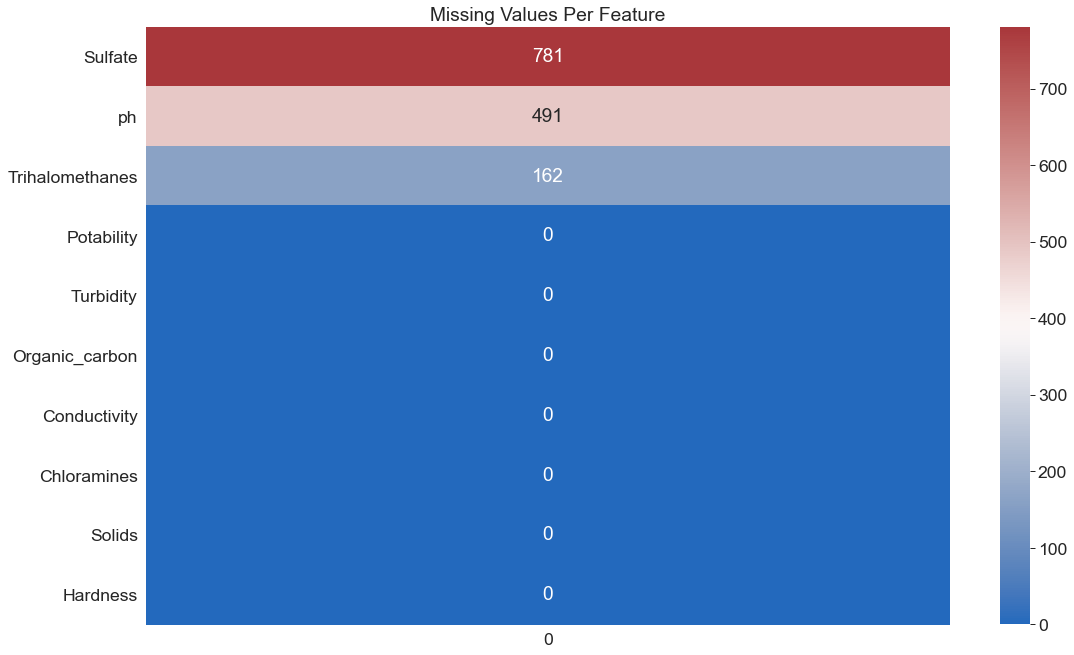

In [5]:
plt.title('Missing Values Per Feature')
nans = water_df.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [6]:
# Impute Missing Values with Label Matching Mean
for col in ['Sulfate','ph','Trihalomethanes']:
    missing_label_0 = water_df.query('Potability == 0')[col][water_df[col].isna()].index
    water_df.loc[missing_label_0,col] = water_df.query('Potability == 0')[col][water_df[col].notna()].mean()

    missing_label_1 = water_df.query('Potability == 1')[col][water_df[col].isna()].index
    water_df.loc[missing_label_1,col] = water_df.query('Potability == 1')[col][water_df[col].notna()].mean()

In [7]:
T = water_df.copy()
T.Potability =  T.Potability.map({1:'Potable',0:'Not Potable'})
ex.pie(T,names='Potability',title='Distribution of Target Labels (Drinkability)')

In [8]:
fig = make_subplots(rows=3, cols=1,shared_xaxes=True,subplot_titles=('Perason Correaltion',  'Spearman Correaltion','Kendall Correlation'))
colorscale=     [[1.0              , "rgb(165,0,38)"],
                [0.8888888888888888, "rgb(215,48,39)"],
                [0.7777777777777778, "rgb(244,109,67)"],
                [0.6666666666666666, "rgb(253,174,97)"],
                [0.5555555555555556, "rgb(254,224,144)"],
                [0.4444444444444444, "rgb(224,243,248)"],
                [0.3333333333333333, "rgb(171,217,233)"],
                [0.2222222222222222, "rgb(116,173,209)"],
                [0.1111111111111111, "rgb(69,117,180)"],
                [0.0               , "rgb(49,54,149)"]]

s_val =water_df.corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',showscale=False,xgap=1,ygap=1,colorscale=colorscale),
    row=1, col=1
)


s_val =water_df.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=1,ygap=1,colorscale=colorscale),
    row=2, col=1
)

s_val =water_df.corr('kendall')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=1,ygap=1,colorscale=colorscale,showscale=False),
    row=3, col=1
)

fig.update_layout(height=700, width=900, title_text="Different Inner Correlations Coefficients")
fig.show()

In [11]:
columns = water_df[['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity']]

<ipython-input-14-a1d0913c68e7>:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



C:\Users\Conner\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Conner\anaconda3\lib\site-packages\seaborn\distributions.py:2055: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.

C:\Users\Conner\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Conner\anaconda3\lib\site-packages\seaborn\distributions.py:2055: FutureWarning:

The `axis` variable is no longer used and will be removed. Inste

ValueError: num must be 1 <= num <= 9, not 10

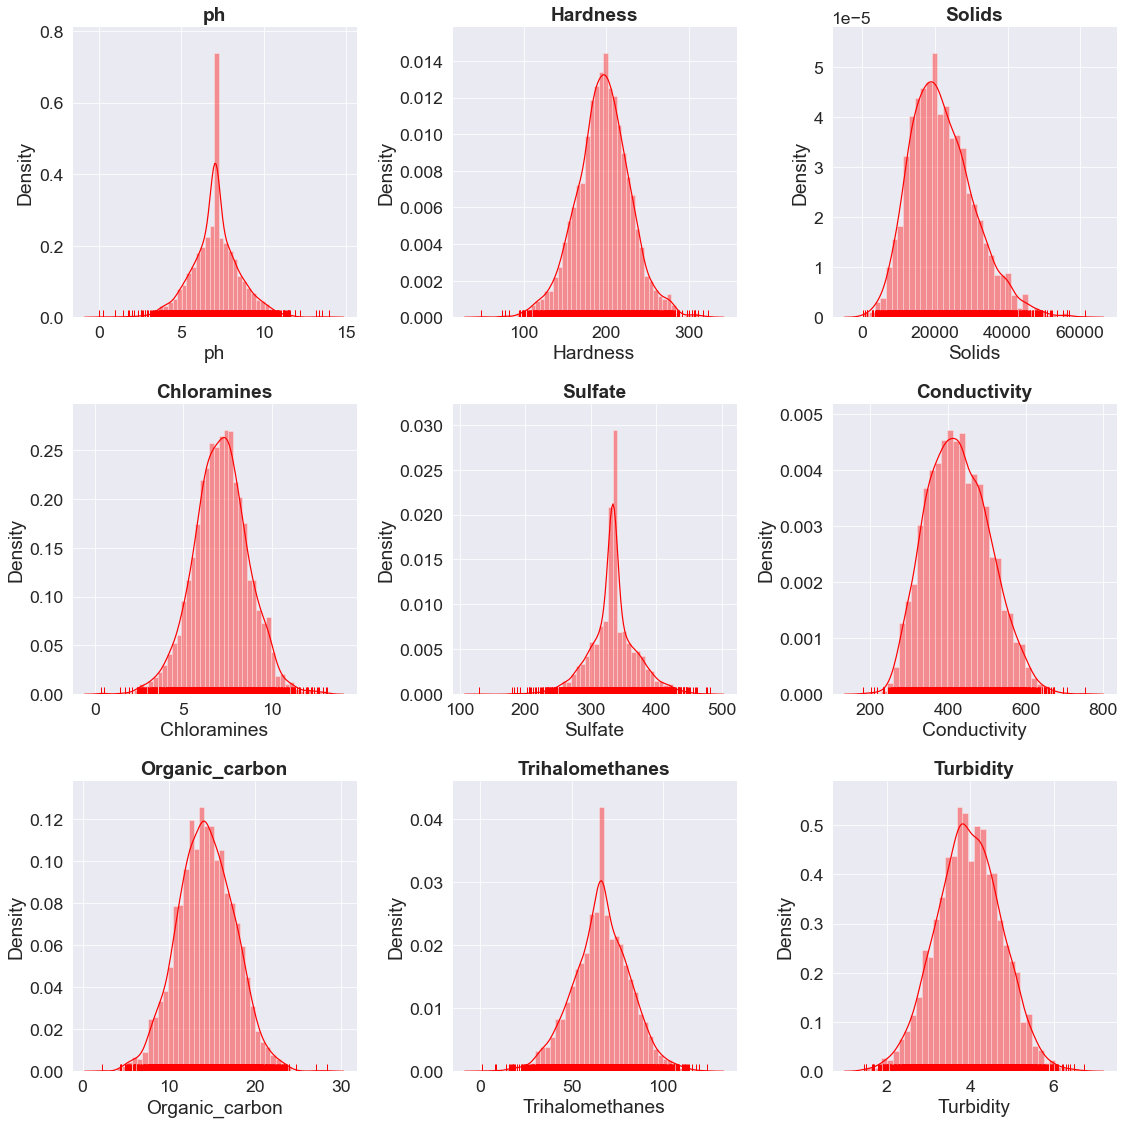

In [14]:
def distributions(data):
    
    
    features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity']
    
    plt.figure(figsize=(16,16))
    for i in tqdm_notebook(range(len(water_df.columns)), desc = 'loading'):
        plt.subplot(3,3,i+1)
        sns.distplot(data[water_df.columns[i]], color='red', rug=True)
        plt.title(water_df.columns[i], weight='bold')
        plt.tight_layout()
        
distributions(columns)

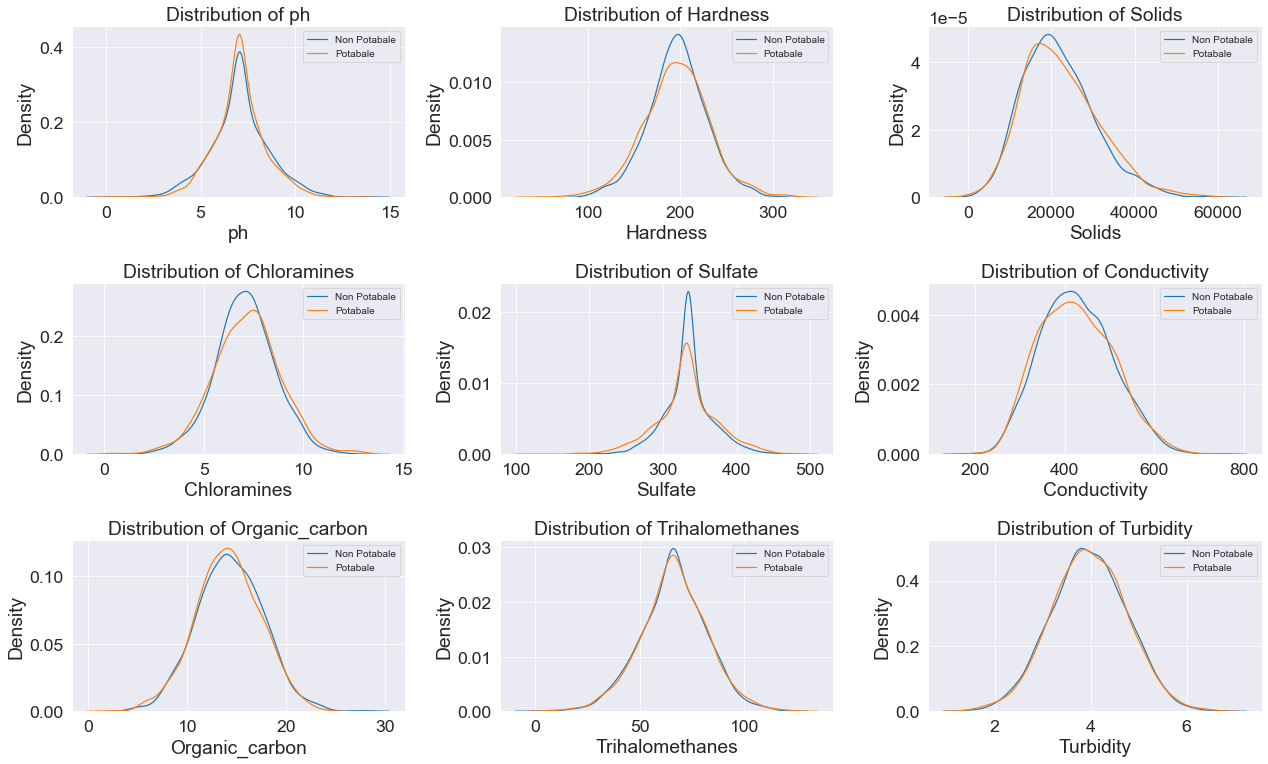

In [16]:
non_potabale = water_df.query('Potability == 0')
potabale     = water_df.query('Potability == 1')

for ax,col in enumerate(water_df.columns[:9]):
    plt.subplot(3,3,ax+1)
    plt.title(f'Distribution of {col}')
    sns.kdeplot(x=non_potabale[col],label='Non Potabale')
    sns.kdeplot(x=potabale[col],label='Potabale')
    plt.legend(prop=dict(size=10))
    

plt.tight_layout()

In [17]:
ttest_results_pvalues,ttest_results_statistic = [],[]
for ax,col in enumerate(water_df.columns[:9]):
    statistic,pvalue = ttest_ind(non_potabale[col],potabale[col])
    ttest_results_pvalues.append(pvalue)
    ttest_results_statistic.append(statistic)
    
ttest_res_df = pd.DataFrame({'S':ttest_results_statistic,'P':ttest_results_pvalues,'F':water_df.columns[:9]})
ttest_res_df = ttest_res_df.sort_values(by='P')

In [18]:
tr  = go.Bar(x=ttest_res_df['F'] ,y=ttest_res_df['P'] ,name='T-test P Value')
tr2 = go.Bar(x=ttest_res_df['F'] ,y=ttest_res_df['S'] ,name='T-test F Statistic')

data = [tr2,tr]
fig = go.Figure(data=data,layout={'title':'T-test Results For Each Feature in Our Dataset','barmode':'overlay'})
fig.show()

In [19]:
mutual_info = []
for i in range(0,9):
    mi = mutual_info_classif(X=water_df.iloc[:,i].to_numpy().reshape(-1, 1),y=water_df.iloc[:,-1],random_state=42)
    mutual_info.append(mi[0])
mutual_info = pd.DataFrame({'Feature':water_df.columns[:9],'MI':mutual_info})
mutual_info = mutual_info.sort_values(by='MI')
tr  = go.Bar(x=mutual_info['Feature'] ,y=mutual_info['MI'] ,name='Mutual Information')

data = [tr]
fig = go.Figure(data=data,layout={'title':'Mutual Information Between Our Features and Potability','barmode':'overlay','yaxis_title':'Mutal Information'})
fig.show()

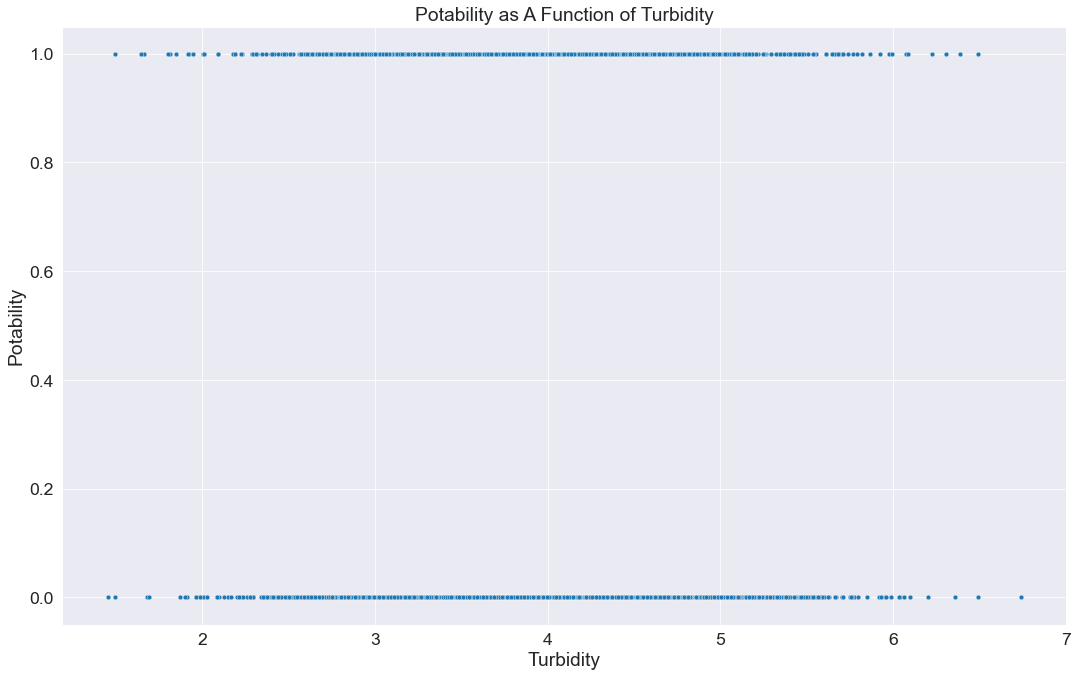

In [20]:
plt.title('Potability as A Function of Turbidity')
sns.scatterplot(x=water_df.iloc[:,8],y=water_df.iloc[:,-1])
plt.show()

In [24]:
N = 5 
pca_pipeline = Pipeline(steps = [
    ('scale',StandardScaler()),
    ('PCA',PCA(N))
])

tf_data = pca_pipeline.fit_transform(water_df.iloc[:,:9])
tf_data = pd.DataFrame({'PC1':tf_data[:,0],'PC2':tf_data[:,1],'PC3':tf_data[:,2],'PC4':tf_data[:,3],'PC5':tf_data[:,4],
                        'label':water_df.iloc[:,-1].map({0:'Not Potabale',1:'Potable'})})

In [25]:
ex.scatter_3d(tf_data,x='PC1',y='PC2',z='PC3',color='label',color_discrete_sequence=['salmon','green'],title=r'$\textit{Data in Reduced Dimension } R^9 \rightarrow R^3$')

In [26]:
components = tf_data[['PC1','PC2','PC3','PC4','PC5']].to_numpy()

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca_pipeline['PCA'].explained_variance_ratio_ * 100)
}

fig = ex.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(N),
    color=tf_data['label'],
    color_discrete_sequence=['salmon','green']
)
fig.update_traces(diagonal_visible=False)
fig.update_layout(title='Data Spread Based on Different 2D Combinations of Principal Components')

fig.show()

In [27]:
evr = pca_pipeline['PCA'].explained_variance_ratio_
total_var = evr.sum() * 100
cumsum_evr = np.cumsum(evr)

trace1 = {
    "name": "individual explained variance", 
    "type": "bar",
    'y':evr}
trace2 = {
    "name": "cumulative explained variance", 
    "type": "scatter", 
     'y':cumsum_evr}
data = [trace1, trace2]
layout = {
    "xaxis": {"title": "Principal components"}, 
    "yaxis": {"title": "Explained variance ratio"},
  }
fig = go.Figure(data=data, layout=layout)
fig.update_layout(title='{:.2f}% of the Original Feature Variance Can Be Explained Using {} Dimensions'.format(np.sum(evr)*100,N))
fig.show()

In [28]:
features = ttest_res_df.iloc[:3,:].F.to_list()
features.append('Turbidity')
train_x,test_x,train_y,test_y = train_test_split(water_df[features],water_df.iloc[:,-1],random_state=42,shuffle=True)

In [29]:
RandomForest_Pipeline     = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
AdaBoost_Pipeline         = Pipeline(steps = [('scale',StandardScaler()),('AB',AdaBoostClassifier(random_state=42))])
SVC_Pipeline              = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(random_state=42))])

RandomForest_CV_f1     = cross_val_score(RandomForest_Pipeline,water_df[features],water_df.iloc[:,-1],cv=10,scoring='f1')
AdaBoost_CV_f1         = cross_val_score(AdaBoost_Pipeline,water_df[features],water_df.iloc[:,-1],cv=10,scoring='f1')
SVC_CV_f1              = cross_val_score(SVC_Pipeline,water_df[features],water_df.iloc[:,-1],cv=10,scoring='f1')

In [30]:
fig = make_subplots(rows=3, cols=1,shared_xaxes=True,subplot_titles=('Random Forest Cross Val Scores',
                                                                     'AdaBoost Cross Val Scores',
                                                                     'SVM Cross Val Scores'))

fig.add_trace(
    go.Scatter(x=np.arange(0,len(SVC_CV_f1)),y=RandomForest_CV_f1,name='Random Forest'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(SVC_CV_f1)),y=AdaBoost_CV_f1,name='AdaBoost'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(SVC_CV_f1)),y=SVC_CV_f1,name='SVM'),
    row=3, col=1
)

fig.update_layout(height=700, width=900, title_text="Different Baseline Models 10 Fold Cross Validation")
fig.update_yaxes(title_text="RMSE")
fig.update_xaxes(title_text="Fold #")

fig.show()

In [ ]:
# RFBE = RandomForestClassifier(random_state=42)

# AdaBoost_Pipeline         = Pipeline(steps = [('scale',StandardScaler()),('AB',AdaBoostClassifier(random_state = 42,
#                                                                                                  base_estimator = RFBE))])

# AdaBoost_Pipeline.fit(train_x,train_y)

# parameters = {'AB__base_estimator__max_depth':[2,3,5],
#               'AB__base_estimator__min_samples_leaf':[2,5,10],
#               'AB__base_estimator__criterion':['entropy','gini'],
#               'AB__base_estimator__bootstrap':[True,False],
#               'AB__n_estimators':[5,10,25],
#               'AB__learning_rate':[0.01,0.1]}

# #ADA_RF_GS  = TuneGridSearchCV(AdaBoost_Pipeline,parameters,cv=3,verbose=1)
# ADA_RF_GS  = GridSearchCV(AdaBoost_Pipeline,parameters,cv=3,verbose=10)
# ADA_RF_GS.fit(water_df[features],water_df.iloc[:,-1])

# print("Best parameter (CV score=%0.3f):" % ADA_RF_GS.best_score_)
# print(ADA_RF_GS.best_params_)

In [ ]:
{'AB__base_estimator__bootstrap': True, 'AB__base_estimator__criterion': 'gini', 'AB__base_estimator__max_depth': 5, 'AB__base_estimator__min_samples_leaf': 10, 'AB__learning_rate': 0.01, 'AB__n_estimators': 5}

In [31]:
RFBE = RandomForestClassifier(random_state=42,bootstrap=True,criterion='gini',max_depth=5,min_samples_leaf=10)
AdaBoost_Pipeline         = Pipeline(steps = [('scale',StandardScaler()),('AB',AdaBoostClassifier(random_state = 42,
                                                                                                 base_estimator = RFBE,
                                                                                                 learning_rate=0.01,
                                                                                                 n_estimators=5))])

AdaBoost_Pipeline.fit(train_x,train_y)
f1 = AdaBoost_Pipeline.score(test_x,test_y)
print('F1 - Score of AdaBoost Model with Random Forest Base Estimators and Cross Validation Grid Search -[',np.round(f1,2),']')

F1 - Score of AdaBoost Model with Random Forest Base Estimators and Cross Validation Grid Search -[ 0.73 ]
